In [25]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from numpy import pi, sqrt, log, sin, cos, exp
from numpy.random import rand

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

1. $p_i$ conjugate to $x_i$ ← 𝒩
2. MD: $x_i(τ)$ and $p_i(τ)$ ← leap frog
- τ: 0 ... $τ_{fin}$ 
$$ H({x},{p})=S({x}) + 0.5∑_i p_i^2 \tag{5.1} $$
3. $H_{init}(τ=0)$ and $H_{fin}(τ_{fin})$.
4. MetroTest: $x_i^{k+1}=[min(1,exp[H_{init}-H_{fin}])]:x_i(τ_{fin}):x_i^k$

# HMC Algo

1. start:
- $ x_i(dt/2) = x_i(0) + p_i(0)⋅dt/2 $
2. MD:
- for $n=1...N_τ-1$:
    - $ p_i(n dt)      = p_i((n-1)dt)   - ∂S_{x_i}((n-1/2)dt)dt $
    - $ x_i((n+1/2)dt) = x_i((n-1/2)dt) + p_i(n dt)dt $
3. finally:
- $ p_i(N_τ dt) = p_i((N_τ-1)dt)    - ∂S_{x_i}((N_τ-1/2)dt)dt $
- $ x_i(N_τ dt) = x_i((N_τ-1/2) dt) + p_i(N_τ dt)dt/2 $


In [26]:
K = 100_000
N_T = 10
dt = 0.1

# random momentum ~ 𝒩
P = sqrt(-2 * log(rand(K))) * sin(2 * pi * rand(K))

# bad idea
# P = (rand(K) - 0.5) * 2.0 * 1


@njit
def S(x):
    """S ≡ Action"""
    return 0.5 * x**2


@njit
def H(x, p):
    """H ≡ Hamiltonian"""
    return S(x) + 0.5 * p**2


@njit
def ΔH(x):
    """∂ₓH"""
    return x


@njit
def MD(k, _x):
    """Molecular Dynamics Evolution
    k - current k
    _x - previous x
    """
    global dt, N_T, P

    p = P[k]
    _H = H(_x, p)
    x = _x + p * 0.5 * dt

    # time step evolution
    for _ in range(N_T):
        dH = ΔH(x)
        p = p - dH * dt
        x = x + p * dt

    # final time step
    dH = ΔH(x)
    p_ = p - dH * dt
    x_ = x + p * 0.5 * dt
    H_ = H(x_, p_)

    return x, _H, H_


@njit
def HMC():
    X = np.full(K, np.nan)
    A = np.full(K, False)  # Accept
    M = rand(K)  # Metropolis

    X[0] = 0

    for k in range(1, K):
        X[k], _H, H_ = MD(k, X[k - 1])
        A[k] = exp(_H - H_) > M[k]
        X[k] = X[k] if A[k] else X[k - 1]

    return X, A


X, A = HMC()


acc_ratio=0.99519


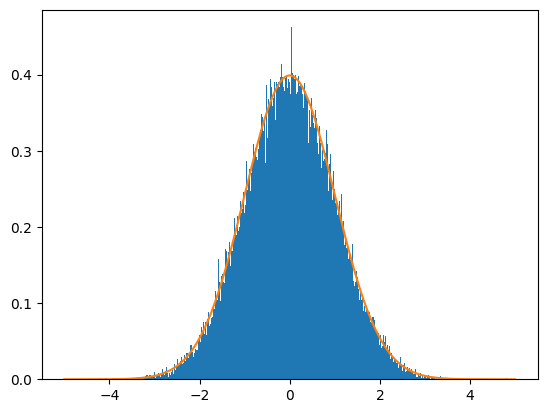

In [27]:
fig, ax = plt.subplots(1, 1)
ax.hist(X, 1_000, density=True)

x = np.linspace(-5, 5, 1000)
y = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-x * x / 2.0)
ax.plot(x, y)

acc_ratio = A.sum() / K

print(f"{acc_ratio=}")